In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
# Modeling
import argparse
import torch
import yaml
from datasets import load_dataset
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchaudio.transforms import FrequencyMasking, TimeMasking
from torchvision.transforms import Compose, Resize
import wandb
from ecallisto_dataset import randomly_reduce_class_samples, EcallistoDataset
from ecallisto_model import ResNet

import wandb
from ecallisto_dataset import (
    preprocess_spectrogram,
    EcallistoDatasetBinary,
)
from ecallisto_model import (
    ResNet,
)
import yaml


print(f'PyTorch version {torch.__version__}')
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = 'cuda'
else:
    print("GPU is not available.")
    device = 'cpu'

/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 2.2.1+cu121
GPU is available: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
ds = load_dataset('i4ds/radio-sunburst-ecallisto-paths-df')

In [3]:
# Transforms
resize_func = Compose(
    [
        Resize([224, 224]),  # Resize the image
    ]
)
data_augm_transform = FrequencyMasking(
    freq_mask_param=90
)


In [4]:
# Transforms

# Data Loader
ds_test = EcallistoDatasetBinary(
    ds['test'],
    resize_func=resize_func,
    data_augm_transform=data_augm_transform,
    normalization_transform=preprocess_spectrogram,
)


test_dataloader = DataLoader(
    ds_test,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    persistent_workers=True,
)


In [5]:
with torch.no_grad():
    for inputs, labels, antennas, datetimes in test_dataloader:
        example = inputs
        break

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/kenfus/FlareSense-v2/ecallisto_dataset.py", line 128, in __getitem__
    image, label, antenna, datetime = super().__getitem__(index)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kenfus/FlareSense-v2/ecallisto_dataset.py", line 65, in __getitem__
    example = self.to_torch_tensor(self.data[index])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kenfus/FlareSense-v2/ecallisto_dataset.py", line 31, in to_torch_tensor
    pd.read_parquet(example["file_path"]).values
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/pandas/io/parquet.py", line 667, in read_parquet
    return impl.read(
           ^^^^^^^^^^
  File "/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/pandas/io/parquet.py", line 267, in read
    path_or_handle, handles, filesystem = _get_path_or_handle(
                                          ^^^^^^^^^^^^^^^^^^^^
  File "/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/pandas/io/parquet.py", line 140, in _get_path_or_handle
    handles = get_handle(
              ^^^^^^^^^^^
  File "/home/kenfus/miniconda3/envs/flaresense-v2/lib/python3.12/site-packages/pandas/io/common.py", line 882, in get_handle
    handle = open(handle, ioargs.mode)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/mnt/nas05/data01/vincenzo/ecallisto/data/MRO_59/0/2023-11-11_10-19-00.parquet'


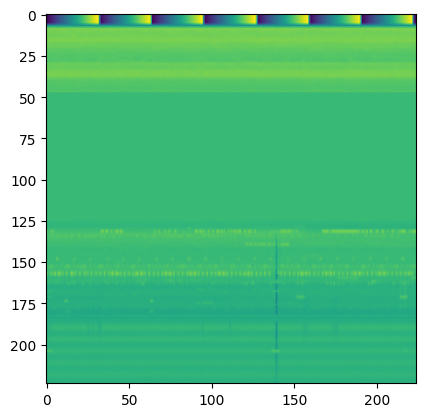

In [85]:
plt.imshow(example.squeeze()[16].numpy())